Dataset Shape: (1000, 9)
Fitting 3 folds for each of 72 candidates, totalling 216 fits


c:\Users\Shravya H Jain\Desktop\Churn\Pingbix_company_interview\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:52:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best XGBoost Params: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}

===== Stacking Ensemble Results =====
Accuracy: 0.9523809523809523
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.95       105
           1       0.97      0.93      0.95       105

    accuracy                           0.95       210
   macro avg       0.95      0.95      0.95       210
weighted avg       0.95      0.95      0.95       210

Confusion Matrix:
 [[102   3]
 [  7  98]]


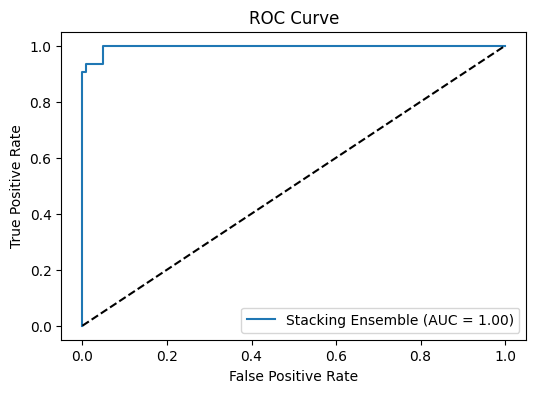

✅ Best model (stacking ensemble) and scaler saved successfully!


In [3]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# =======================
# Step 1: Load Data
# =======================
df = pd.read_csv("bank_churn_dataset.csv")
print("Dataset Shape:", df.shape)

# =======================
# Step 2: Preprocessing
# =======================
if "CustomerId" in df.columns:
    df.drop(["CustomerId"], axis=1, inplace=True)
if "Surname" in df.columns:
    df.drop(["Surname"], axis=1, inplace=True)

if "Gender" in df.columns:
    le = LabelEncoder()
    df["Gender"] = le.fit_transform(df["Gender"])  # Male=1, Female=0

# Feature Engineering
df["BalanceSalaryRatio"] = df["Balance"] / (df["EstimatedSalary"] + 1)
df["AgeNumProducts"] = df["Age"] * df["NumOfProducts"]
df["CreditAgeRatio"] = df["CreditScore"] / (df["Age"] + 1)

X = df.drop("Exited", axis=1)
y = df["Exited"]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Handle imbalance with SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_scaled, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42, stratify=y_res
)

# =======================
# Step 3: Hyperparameter Tuning (XGBoost)
# =======================
params = {
    "n_estimators": [200, 500],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

xgb = XGBClassifier(eval_metric="logloss", random_state=42, use_label_encoder=False)
grid = GridSearchCV(xgb, params, cv=3, scoring="accuracy", verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

best_xgb = grid.best_estimator_
print("Best XGBoost Params:", grid.best_params_)

# =======================
# Step 4: Stacking Ensemble
# =======================
stack = StackingClassifier(
    estimators=[
        ("rf", RandomForestClassifier(n_estimators=500, random_state=42)),
        ("gb", GradientBoostingClassifier(random_state=42)),
        ("xgb", best_xgb)
    ],
    final_estimator=LogisticRegression(max_iter=1000),
    n_jobs=-1
)

stack.fit(X_train, y_train)
y_pred = stack.predict(X_test)

# =======================
# Step 5: Evaluation
# =======================
acc = accuracy_score(y_test, y_pred)
print("\n===== Stacking Ensemble Results =====")
print("Accuracy:", acc)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# ROC Curve
y_prob = stack.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"Stacking Ensemble (AUC = {auc(fpr,tpr):.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# =======================
# Step 6: Save Model
# =======================
joblib.dump(stack, "best_churn_model1.pkl")
joblib.dump(scaler, "scaler1.pkl")
print("✅ Best model (stacking ensemble) and scaler saved successfully!")
